# Load Data

In [1]:
import sys
sys.path.append("..")
from src import tools
from ipywidgets import interact, interact_manual
import ipywidgets as widgets
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas_profiling
%matplotlib inline


def absoluteFilePaths(directory):
    for dirpath, _, filenames in os.walk(directory):
        for f in filenames:
            if str(f)[0] == '.':
                pass
            else:
                yield os.path.abspath(os.path.join(dirpath, f))


FOLDER = "../outputs/fb/summary/"


def load_data(folder):
    files = absoluteFilePaths(folder)
    users = []
    data = {}
    for f in files:
        df = pd.read_csv(f)
        user = df.user.iloc[0]
        data.update({user: df})
    return data


data = load_data(FOLDER)
print(data.keys())

dict_keys(['gelato-pizza-zucchini', 'eggs-macaroon-pretzel', 'fennel-tea-lime', 'mango-macaroons-macaroni', 'yams-pomelo-guava', 'yolk-carnitas-date', 'pickles-coleslaw-rhubarb', 'asparagus-croissant-kiwi', 'vanilla-bokchoy-corn', 'coleslaw-ceviche-broccoli', 'parsnip-lentils-fudge', 'waffle-hamburger-souffle', 'quince-peanut-molasses', 'croissant-watercress-pudding', 'kale-sushi-eggs', 'coconut-fudge-mandarin', 'pimiento-cranberry-samosa', 'vinegar-arrugula-biscuit', 'hummus-orzo-romaine', 'pistachio-salsa-tangelo'])


# Clean Data

## Drop columns, set datetimeindex, fill missing data and generate statistics.

In [2]:
start_date = '2019-10-15'
end_date = '2020-02-06'

def clean(df):
    df = df[pd.notnull(df['source'])]
    df = df[['impressionOrder', 'id', 'nature',
             'source',  'fblinktype', 'texts',
             'textsize', 'timeline', 'user']]
    return df

stats = pd.DataFrame(columns=['start', 'end',
                              'average_impression_count',
                              'timelines',
                              'total_entries',
                              'missing values'
                              ])

for user, df in data.items():
    try:
        df = df.drop('Unnamed: 0', 1)
    except:
        pass

    df = df[['impressionTime', 'impressionOrder',  'id',
             'nature',  'postId', 'publicationTime', 'permaLink',
             'source', 'sourceLink', 'fblinktype',
             'texts', 'textsize', 'images',
             'semanticCount', 'semanticId', 'timeline', 'user']]

    df.index = df['impressionTime']
    df.index = pd.to_datetime(df.index)
    df = df[end_date:start_date]

    df.publicationTime = pd.to_datetime(df.publicationTime)
    df.impressionOrder = pd.to_numeric(df.impressionOrder, downcast='integer')

    df = df.replace("nan", np.nan)
    df = df.replace("", np.nan)
    df['fblinktype'] = df['fblinktype'].fillna('other')

    # AUTOMATE THIS
    link_source_dict = {
        'https://www.facebook.com/AgenziaANSA/': 'ANSA.it',
        'https://www.facebook.com/AgenziaAdnKronos/': 'Adnkronos',
        'https://www.facebook.com/corrieredellasera/': 'Corriere della Sera',
        'https://www.facebook.com/giorgiameloni.paginaufficiale/': 'Giorgia Meloni',
        'https://www.facebook.com/HuffPostItalia/': 'HuffPost Italia',
        'https://www.facebook.com/ilfoglio/': 'Il Foglio',
        'https://www.facebook.com/ilGiornale/': 'Il Giornale',
        'https://www.facebook.com/italiaviva/': 'Italia Viva',
        'https://www.facebook.com/la7fb/': 'La7',
        'https://www.facebook.com/lastampa.it/': 'La Stampa',
        'https://www.facebook.com/legasalvinipremier/': 'Lega - Salvini Premier',
        'https://www.facebook.com/liberonews/': 'Libero',
        'https://www.facebook.com/LuigiDiMaio/': 'Luigi Di Maio',
        'https://www.facebook.com/matteorenziufficiale/': 'Matteo Renzi',
        'https://www.facebook.com/Messaggero.it/': 'Il Messaggero.it',
        'https://www.facebook.com/partitodemocratico/': 'Partito Democratico',
        'https://www.facebook.com/rainews.it/': 'Rainews.it',
        'https://www.facebook.com/Repubblica/': 'la Repubblica',
        'https://www.facebook.com/salviniofficial/': 'Matteo Salvini'}

    df['source'] = df['source'].fillna(df['sourceLink'])
    df = df.replace({"source": link_source_dict})

    stats.loc[user] = [
        df.impressionTime.min(),
        df.impressionTime.max(),
        # max(df.impressionOrder),
        #min(df.groupby(['timeline'], sort=False)['impressionOrder'].max()),
        df.impressionOrder.mean(),
        df['timeline'].nunique(),
        df['id'].count(),
        df.isna().sum().sum()
    ]
    data[user] = df.copy()

df = pd.concat(data.values())

df = clean(df)
stats

,start,end,average_impression_count,timelines,total_entries,missing values
gelato-pizza-zucchini,2019-10-22 11:01:56+00:00,2020-02-03 15:07:48+00:00,19.177669,961,18163,432
eggs-macaroon-pretzel,2019-10-21 15:53:23+00:00,2020-02-03 15:07:39+00:00,18.575860,986,19279,501
fennel-tea-lime,2019-10-21 09:34:22+00:00,2020-01-01 19:06:06+00:00,19.410764,777,14512,442
mango-macaroons-macaroni,2019-10-16 14:46:34+00:00,2020-02-05 08:15:08+00:00,19.510745,884,15217,3394
yams-pomelo-guava,2019-10-21 16:53:49+00:00,2020-01-13 19:06:09+00:00,19.244684,955,18530,585
yolk-carnitas-date,2019-10-19 10:45:02+00:00,2020-02-03 15:07:36+00:00,20.215725,990,19358,24155
pickles-coleslaw-rhubarb,2019-10-20 12:34:11+00:00,2020-02-05 10:07:40+00:00,18.742486,912,16702,517
asparagus-croissant-kiwi,2019-10-19 11:11:43+00:00,2020-02-03 15:07:25+00:00,18.732350,917,16955,400
vanilla-bokchoy-corn,2019-10-21 10:35:13+00:00,2020-01-30 10:05:45+00:00,19.732927,822,14423,18128
coleslaw-ceviche-broccoli,2019-10-20 11:08:47+00:00,2020-02-03 07:20:07+00:00,19.142758,947,17253,23709


## Replace pseudo-names with "real" user names

In [3]:
user_names = pd.read_csv("../config/users.csv")
names_dict = {}

for name, number, token in user_names.values:
    temp_df = pd.read_csv('../outputs/fb/summary/'+token+'.csv', nrows=2)
    names_dict[temp_df.user[0]] = name

df = df.replace({"user": names_dict})

In [4]:
# data['parsnip-lentils-fudge'].drop('impressionTime',1).profile_report(check_correlation_cramers=False,
#                  check_correlation_pearson=False,
#                  cardinality_threshold=len(df)*0.9,
#                  style={'full_width':True}
#                                          )

# Explore

## Profile Report (takes a while)

In [5]:
#df.profile_report(check_correlation_cramers=False,
#                          check_correlation_pearson=False,
#                          cardinality_threshold=len(df)*0.9,
#                          style={'full_width': True})

## Post Count per column

In [6]:
def postCountGraph(df, user, column):
    #data = tools.setDatetimeIndexFloor(tools.setDatetimeIndex(df), what="1D")
    data = df
    data = data.groupby(data.index)[column].count()
    data = data.to_frame()

    fig, ax = plt.subplots(figsize=(15, 7))

    # set ticks every week
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.set_title('Number of entries in col '+column +
                 ' collected per day for: '+user)
    ax.bar(data.index, data[column])
    return(fig, ax)


#fig, ax = (dailyPostCountGraph(df, user))

@interact
def show_plot(user=df['user'].unique(), column=df.columns):
    return postCountGraph(df[df['user']==user], user, column)

interactive(children=(Dropdown(description='user', options=('Kris', 'Erwijn', 'Martijn', 'Nienke', 'Doortje', …

## Post Count per Dates

In [7]:
def datesPostCountGraph(df, user):
    data = tools.setDatetimeIndexFloor(df, what="1D")
    data = data.groupby(data.index).id.count()
    data = data.to_frame()

    fig, ax = plt.subplots(figsize=(15, 7))

    # set ticks every week
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.set_title('Number of posts collected per day for user: '+user)
    ax.bar(data.index, data.id)
    return(fig, ax)


#fig, ax = (dailyPostCountGraph(df, user))

@interact
def show_plot(user=df['user'].unique(), start_date="2019-10-12", end_date="2020-01-03"):
    mask = (df['user'] == user)
    return datesPostCountGraph(df[mask].loc[end_date:start_date], user)

interactive(children=(Dropdown(description='user', options=('Kris', 'Erwijn', 'Martijn', 'Nienke', 'Doortje', …

## How many total entries i would have if i exclude days that have less than n entries?

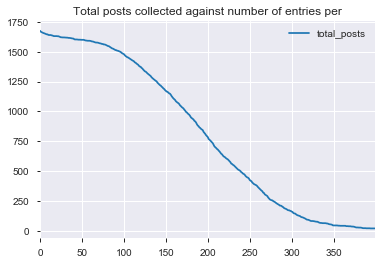

In [8]:
def dailyPostCount(df):
    data = tools.setDatetimeIndexFloor(df, what="1D")
    data = data.groupby([data.index, data.user]).id.count()
    data = data.to_frame()
    return data


count = dailyPostCount(df)

where_to_cut = pd.DataFrame(columns=['total_posts'])
for i in range(0, 400):
    l = len(count[(count['id'] > i)])

    where_to_cut.loc[i] = [
        l
    ]
where_to_cut.plot(title='Total posts collected against number of entries per')

## Generate stats (missing values, timeframes, timelines..) per user

In [9]:
stats = pd.DataFrame(columns=['start', 'end',
                              'average_impression_count',
                              'timelines',
                              'total_entries',
                              'missing values'
                              ])


def getStats(df):
    user_list = df.user.unique()
    for user in user_list:
        data = df[(df['user'] == user)]

        stats.loc[user] = [
            data.index.min(),
            data.index.max(),
            # max(df.impressionOrder),
            #min(df.groupby(['timeline'], sort=False)['impressionOrder'].max()),
            data.impressionOrder.mean(),
            data['timeline'].nunique(),
            data['id'].count(),
            data.isna().sum().sum()
        ]
    return stats


stats = getStats(df)

stats

,start,end,average_impression_count,timelines,total_entries,missing values
Kris,2019-10-22 00:00:00+00:00,2020-02-03 00:00:00+00:00,19.177669,961,18163,0
Erwijn,2019-10-21 00:00:00+00:00,2020-02-03 00:00:00+00:00,18.575860,986,19279,0
Martijn,2019-10-21 00:00:00+00:00,2020-01-01 00:00:00+00:00,19.410764,777,14512,0
Nienke,2019-10-16 00:00:00+00:00,2020-02-05 00:00:00+00:00,19.510745,884,15217,0
Doortje,2019-10-21 00:00:00+00:00,2020-01-13 00:00:00+00:00,19.244684,955,18530,0
Gert,2019-10-19 00:00:00+00:00,2020-02-03 00:00:00+00:00,20.215725,990,19358,1
Bjoke,2019-10-20 00:00:00+00:00,2020-02-05 00:00:00+00:00,18.742486,912,16702,0
Hanneke,2019-10-19 00:00:00+00:00,2020-02-03 00:00:00+00:00,18.732350,917,16955,0
Omar,2019-10-21 00:00:00+00:00,2020-01-30 00:00:00+00:00,19.732927,822,14423,0
Ivo,2019-10-20 00:00:00+00:00,2020-02-03 00:00:00+00:00,19.142758,947,17253,0


## Distribution of total entries collected per timeline

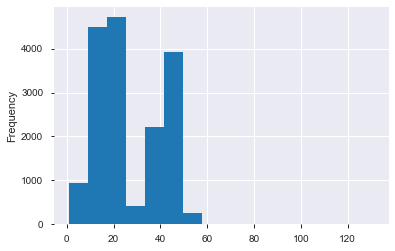

In [10]:
df.groupby(['timeline'])['impressionOrder'].max().plot.hist(bins=16)

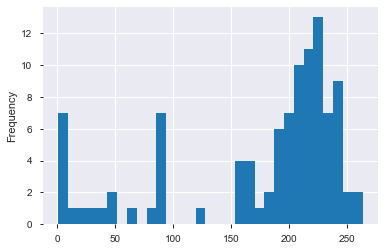

In [11]:
result = df
result.index = result.index.floor('H')
names = result.groupby(df.index).user.unique()
timelines = result.groupby(df.index).timeline.unique()
result = pd.DataFrame(names)
result.columns = ['names']
result['users_count'] = result['names'].str.len()
result['timelines'] = timelines
result['timelines_count'] = result['timelines'].str.len()

# result.users_count.plot.hist(bins=5)
result.timelines_count.plot.hist(bins=31)

## Distribution of number of timelines per hour

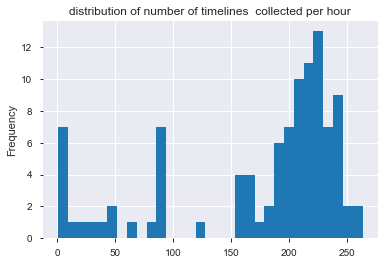

In [12]:
result.timelines_count.plot.hist(
    bins=31, title='distribution of number of timelines  collected per hour')

## Distribution of number of active (collecting data) users per hour

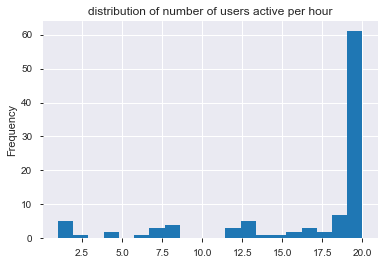

In [13]:
result.users_count.plot.hist(
    bins=20, title='distribution of number of users active per hour')

## How many hours of data do i get if i only select hours where at least n users were collecting data?

In [14]:
print('timelines seen by all users: ' +
      str(len(result[(result['users_count'] == 20) & (result['timelines_count'] >= 20)]))+' hours')

print('timelines seen by at least 16 users: ' +
      str(len(result[(result['users_count'] >= 16) & (result['timelines_count'] >= 16)]))+' hours')

print('timelines seen by at least 10 users: ' +
      str(len(result[(result['users_count'] >= 10) & (result['timelines_count'] >= 10)]))+' hours')

print('all data: '+str(len(result))+' hours')

timelines seen by all users: 61 hours
timelines seen by at least 16 users: 75 hours
timelines seen by at least 10 users: 85 hours
all data: 101 hours


# Preparing the Data

## Set timeframes

In [15]:
#timeframe_all = ['2019-11-01','2019-12-31']
#pre_polarization = ['2019-11-02','2019-11-19']
#during_polarization = ['2019-11-20','2019-12-05']
#after_polarization = ['2019-12-05','2019-12-10']
#after_polarization_with_likes = ['2019-12-10','2019-12-27']

## Remove all the timelines that have less than 10 entries

In [16]:
df_wip = df.loc['2019-11-01':'2019-12-31']
timelines = df_wip.groupby('timeline')['impressionOrder'].max()

print('Before: {}'.format(len(df_wip)))
df_wip = df_wip[df_wip.timeline.isin(list(timelines[timelines > 10].index))]
print('After: {}'.format(len(df_wip)))

Before: 232162
After: 225997


In order to understand what is the best combination of users which will provide the longest dataset possible given a minimun number of users, we must:
- generate list of lists with the possible combinations >= of 16 elements (8 per group)
- filter df and check len by combination
- output top 5 combinations with len

## What is the combination of 16 or more users i should use to keep as much data as possible?

In [17]:
result.names = result.names.apply(sorted)
result = result[result['users_count'] >= 16]
result = result.loc['2019-11-01':'2019-12-31']


from IPython.display import clear_output, display
import itertools


def user_combinations(trimmed=result, n_users=16):
    list_of_all_users_name = sorted(trimmed.names.iloc[0])
    print(list_of_all_users_name)

    combinations = set(
        list(itertools.combinations(list_of_all_users_name, n_users)))

    d = {}
    n = 0
    for i in combinations:
        n += 1
        clear_output(wait=True)
        print(str(n)+'/'+str(len(combinations)))
        for index, row in result.iterrows():
            check = all(item in row.names for item in i)
            if check:
                nam = str(i)
                if nam in d:
                    d[nam] += 1
                else:
                    d[nam] = 1
            else:
                pass
    user_combinations_dict = {k: v for k, v in sorted(
        d.items(), key=lambda item: item[1], reverse=True)}

    return user_combinations_dict


#user_combinations_dict = user_combinations()
# list(user_combinations_dict.items())[0]

Now we know that the best combination of users is "('Aarend', 'Bjoke', 'Cor Timmerman', 'Doortje', 'Erwijn', 'Hanneke', 'Juultje', 'Kris', 'Lonneke', 'Martijn', 'Nienke', 'Omar', 'Phoebe', 'Quintijn', 'Stephan', 'Terese')". We want a list of these timelines in order to filter the dataframe and only keep those.

In [18]:
filter_lst = ['Aarend', 'Bjoke', 'Cor Timmerman', 'Doortje', 'Erwijn', 'Hanneke', 'Juultje',
              'Kris', 'Lonneke', 'Martijn', 'Nienke', 'Omar', 'Phoebe', 'Quintijn', 'Stephan', 'Terese']

timelines_to_keep = []

for index, row in result.iterrows():
    if all(n in row.names for n in filter_lst):
        timelines_to_keep.append(list(row.timelines))
    else:
        pass

timelines_to_keep = [item for sublist in timelines_to_keep for item in sublist]

## Keep only timelines with appropriate combination of users

In [19]:
print('Before: {}'.format(len(df_wip)))
df_wip = df_wip[df_wip.timeline.isin(timelines_to_keep)]
print('After: {}'.format(len(df_wip)))

Before: 225997
After: 211421


In [20]:
#df_wip = df_wip.replace({"user": names_dict})

In [21]:
sources_to_remove = ['Jair Messias Bolsonaro',
                     'Donald J. Trump', 'Marine Le Pen']  # E TRUMP
print('Before: {}'.format(len(df_wip)))
df_wip = df_wip[~df_wip.source.isin(sources_to_remove)]
print('After: {}'.format(len(df_wip)))

Before: 211421
After: 210095


In [22]:
users_to_keep = ['Bjoke', 'Cor Timmerman', 'Doortje', 'Erwijn', 'Hanneke', 'Juultje',
                 'Kris', 'Lonneke', 'Martijn', 'Nienke', 'Omar', 'Phoebe', 'Quintijn', 'Stephan']
print('Before: {}'.format(len(df_wip)))
df_wip = df_wip[df_wip['user'].isin(users_to_keep)]
print('After: {}'.format(len(df_wip)))

Before: 210095
After: 150753


In [23]:
df_wip.to_csv('dataset.csv')

# Normalize and Plot

In [24]:
left_media = ['la Repubblica',
              'il manifesto',
              'Open',
              'La7'
              ]

neutral_media = ['ANSA.it',
                 'Adnkronos'
                 ]

right_media = ['Il Sole 24 ORE',
               'Il Giornale',
               'Corriere della Sera',
               'Tgcom24',
               'Libero',
               'Sky TG24'
               ]

left_politics = ['Partito Democratico',
                 'Italia Viva',
                 'Matteo Renzi',
                 'Giuseppe Conte',
                 'Pietro Grasso'
                ]

right_politics = ['Lega - Salvini Premier',
                  'Matteo Salvini',
                  'Giorgia Meloni',
                  "Fratelli d'Italia",
                  'Silvio Berlusconi'
                  ]

In [25]:
from collections import defaultdict
import os
from datetime import datetime
from scipy.stats import ttest_ind
from numpy import mean
# set constants

sources_dx = right_politics
sources_sx = left_politics

start_collection = '2019-11-01'
start_polarization = '2019-11-20'


timerange = ('2019-12-05',
             '2019-12-10')

adjusted = True

folder = '../outputs/fb/summary'
file_users = '../config/users.csv'

In [26]:
def count_source(impressions, source):
    sources_users = {"source": [],
                     "user": [],
                     "count": []}
    for user, user_impressions in impressions.groupby('user'):
        sources_users["source"].append(source)
        sources_users["user"].append(user)
        sources_users["count"].append(user_impressions[user_impressions["source"] == source]["source"].count())
    return pd.DataFrame(data=sources_users)


def users_dx_and_sx(source_r, sources_l, impressions):
    sources_users = count_source(impressions, source_r)
    sources_users = sources_users[['user', 'count']]
    sources_users.columns = ['user', 'dx']
    sources_users['sx'] = count_source(impressions, source_l)['count']
    return sources_users

for source_r in sources_dx:
    for source_l in sources_sx:
        impressions = df_wip[['user', 'source']]

        # filter out for desired time range for experiment

        impressions_exp = impressions[(impressions.index >= timerange[0])
                                      & (impressions.index <= timerange[1])]

        impressions_pre = impressions[(impressions.index <= start_polarization) & (
            impressions.index >= start_collection)]

        # count specific sources per user


        sources_users_exp = users_dx_and_sx(source_r, source_l, impressions_exp)
        sources_users_pre = users_dx_and_sx(source_r, source_l, impressions_pre)

        sources_users_exp['ratio_dx-sx'] = sources_users_exp['dx'] / \
            sources_users_exp['sx']

        #sources_users_exp['ratio_dx-sx_adj'] = (sources_users_exp['dx']/sources_users_pre['dx'])/(sources_users_exp['sx']/sources_users_pre['sx'])
        sources_users_exp['ratio_dx-sx_adj'] = (sources_users_exp['dx'].divide(
            sources_users_pre['dx']))/(sources_users_exp['sx'].divide(sources_users_pre['sx']))

        # add column with test group the user belongs to
        polarized_users = ('Aarend', 'Bjoke', 'Cor Timmerman', 'Doortje',
                           'Erwijn', 'Friedie', 'Gert', 'Hanneke', 'Ivo', 'Juultje')

        sources_users_exp["user_group"] = ["polarized" if user in polarized_users
                                           else "control"
                                           for user in sources_users_exp["user"]]


        # compare means and run t-test
        if adjusted:
            testing_var = 'ratio_dx-sx_adj'
        else:
            testing_var = 'ratio_dx-sx'

        polarized = sources_users_exp[sources_users_exp['user_group']
                                      == 'polarized'][testing_var]  # or _adj
        control = sources_users_exp[sources_users_exp['user_group']
                                    == 'control'][testing_var]


        statistic, pvalue = ttest_ind(polarized, control)
        if pvalue <= 0.05:
            print(source_r+'/'+source_l)
            print('Polarized = '+str(mean(polarized)))
            print('Control = '+str(mean(control)))
            print('Statistic: {}'.format(statistic))
            print('Pvalue: {}'.format(pvalue))

Lega - Salvini Premier/Partito Democratico
Polarized = 1.6294296793584504
Control = 0.9278157805965792
Statistic: 2.7015250085318856
Pvalue: 0.019254969970947163
Lega - Salvini Premier/Italia Viva
Polarized = 2.5874801786394195
Control = 0.876858956941289
Statistic: 3.3512978942889142
Pvalue: 0.005766278836337836
Lega - Salvini Premier/Matteo Renzi
Polarized = 1.1438802408895044
Control = 0.48229642882415424
Statistic: 4.271530580796261
Pvalue: 0.001085144212321104


/Users/macbook/PycharmProjects/dashboard/venv3/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/macbook/PycharmProjects/dashboard/venv3/lib/python3.7/site-packages/scipy/stats/stats.py:4331: RuntimeWarning: invalid value encountered in double_scalars
  d = mean1 - mean2


Matteo Salvini/Partito Democratico
Polarized = 1.9818419420989761
Control = 1.0882474991260433
Statistic: 3.090969912780113
Pvalue: 0.009345477691975615
Matteo Salvini/Italia Viva
Polarized = 2.9203454150578687
Control = 1.0665879488746146
Statistic: 5.26498100702763
Pvalue: 0.00019944134220518058
Matteo Salvini/Matteo Renzi
Polarized = 1.3895677967694782
Control = 0.5685327467867027
Statistic: 4.107321306807436
Pvalue: 0.0014532121446258486


Text(0.5, 0.98, 'Right/Left count ratio - Adjusted')

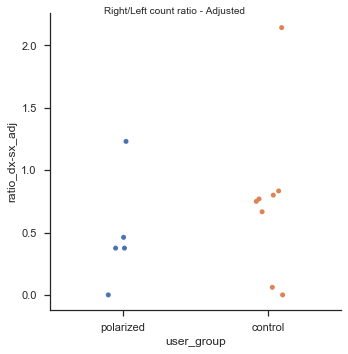

In [27]:
import seaborn as sns
%matplotlib inline

title = 'Right/Left count ratio'

if adjusted:
    title = title+" - Adjusted"
else:
    pass

sns.set(style="ticks", color_codes=True)
groups_data = sources_users_exp[[testing_var, "user_group"]]
sns.catplot(x="user_group", y=testing_var, data=groups_data).fig.suptitle(title, fontsize=10)

In [28]:
display(groups_data)

,ratio_dx-sx_adj,user_group
0,0.375000,polarized
1,0.461538,polarized
2,NaN,polarized
3,1.230769,polarized
4,0.000000,polarized
5,0.375000,polarized
6,0.769231,control
7,0.060870,control
8,2.142857,control
9,0.000000,control


In [29]:
all_sources = ['Lega - Salvini Premier',
               'Il Sole 24 ORE',
               'Partito Democratico',
               #'Il Foglio',
               #'il Post',
               'la Repubblica',
               'il manifesto',
               'Il Giornale',
               'Corriere della Sera',
               'Italia Viva',
               'Sky TG24',
               #'MoVimento 5 Stelle',
               'ANSA.it',
               #'Il Fatto Quotidiano',
               #'La Stampa',
               'Matteo Salvini',
               'Tgcom24',
               'Adnkronos',
               #'HuffPost Italia',
               #'Il Messaggero.it',
               #'La Nazione',
               'Giorgia Meloni',
               #'Luigi Di Maio',
               #'Rainews.it',
               'La7',
               "Fratelli d'Italia",
               'Open',
               'Libero',
               'Matteo Renzi',
               'Silvio Berlusconi',
               'Giuseppe Conte',
               'Pietro Grasso']

# impressionTime

In [30]:
throw error

SyntaxError: invalid syntax (<ipython-input-30-1fc2653bf436>, line 1)

In [39]:


sources_dx = right_media
sources_sx = left_media

start_collection = '2019-11-01'
start_polarization = '2019-11-20'


timerange = ('2019-12-05',
             '2019-12-10')

adjusted = True

folder = '../outputs/fb/summary'
file_users = '../config/users.csv'

In [40]:
def mean_order(impressions, source):
    sources_users = {"source": [],
                     "user": [],
                     "mean": []}
    for user, user_impressions in impressions.groupby('user'):
        sources_users["source"].append(source)
        sources_users["user"].append(user)
        sources_users["mean"].append(user_impressions[user_impressions["source"] == source]["impressionOrder"].mean())
    return pd.DataFrame(data=sources_users)


def users_dx_and_sx(source_r, sources_l, impressions):
    sources_users = mean_order(impressions, source_r)
    sources_users = sources_users[['user', 'mean']]
    sources_users.columns = ['user', 'dx']
    sources_users['sx'] = mean_order(impressions, source_l)['mean']
    return sources_users

impressions = df_wip[['user', 'source', 'impressionOrder']] # was inside for loop

for source_r in sources_dx:
    for source_l in sources_sx:
        

        # filter out for desired time range for experiment

        impressions_exp = impressions[(impressions.index >= timerange[0])
                                      & (impressions.index <= timerange[1])]

        impressions_pre = impressions[(impressions.index <= start_polarization) & (
            impressions.index >= start_collection)]

        # count specific sources per user


        sources_users_exp = users_dx_and_sx(source_r, source_l, impressions_exp)
        sources_users_pre = users_dx_and_sx(source_r, source_l, impressions_pre)

        sources_users_exp['ratio_dx-sx'] = sources_users_exp['dx'] / \
            sources_users_exp['sx']

        #sources_users_exp['ratio_dx-sx_adj'] = (sources_users_exp['dx']/sources_users_pre['dx'])/(sources_users_exp['sx']/sources_users_pre['sx'])
        sources_users_exp['ratio_dx-sx_adj'] = (sources_users_exp['dx'].divide(
            sources_users_pre['dx']))/(sources_users_exp['sx'].divide(sources_users_pre['sx']))

        # add column with test group the user belongs to
        polarized_users = ('Aarend', 'Bjoke', 'Cor Timmerman', 'Doortje',
                           'Erwijn', 'Friedie', 'Gert', 'Hanneke', 'Ivo', 'Juultje')

        sources_users_exp["user_group"] = ["polarized" if user in polarized_users
                                           else "control"
                                           for user in sources_users_exp["user"]]


        # compare means and run t-test
        if adjusted:
            testing_var = 'ratio_dx-sx_adj'
        else:
            testing_var = 'ratio_dx-sx'

        polarized = sources_users_exp[sources_users_exp['user_group']
                                      == 'polarized'][testing_var]  # or _adj
        control = sources_users_exp[sources_users_exp['user_group']
                                    == 'control'][testing_var]


        statistic, pvalue = ttest_ind(polarized, control)
        if pvalue <= 0.05:
            print(source_r+'/'+source_l)
            print('Polarized = '+str(mean(polarized)))
            print('Control = '+str(mean(control)))
            print('Statistic: {}'.format(statistic))
            print('Pvalue: {}'.format(pvalue))

Corriere della Sera/Open
Polarized = 0.8262455869463697
Control = 1.0264633474872185
Statistic: -2.64293491626639
Pvalue: 0.021457167816962608
Libero/Open
Polarized = 0.7037683462311134
Control = 1.025751507419268
Statistic: -3.1455858756661814
Pvalue: 0.008443863374312187


Text(0.5, 0.98, 'Right/Left count ratio - Adjusted')

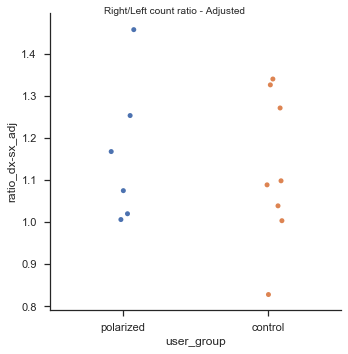

In [41]:
import seaborn as sns
%matplotlib inline

title = 'Right/Left count ratio'

if adjusted:
    title = title+" - Adjusted"
else:
    pass

sns.set(style="ticks", color_codes=True)
groups_data = sources_users_exp[[testing_var, "user_group"]]
sns.catplot(x="user_group", y=testing_var, data=groups_data).fig.suptitle(title, fontsize=10)

In [42]:
display(groups_data)

,ratio_dx-sx_adj,user_group
0,1.075176,polarized
1,1.006391,polarized
2,1.020206,polarized
3,1.253901,polarized
4,1.458340,polarized
5,1.168196,polarized
6,1.088944,control
7,1.340851,control
8,0.827921,control
9,1.039008,control
